In [8]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
from image_processing import ImageProcessing
from tqdm import tqdm
import scienceplots
plt.style.use(['science', 'ieee', 'std-colors'])
plt.rcParams['font.size'] = 10
plt.rcParams.update({'figure.dpi': '100'})
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
# Define paths
DATASET_FOLDER = "/home/mariopasc/Python/Datasets/Meningiomas/Meningioma_Adquisition"
METADATA_PATH = os.path.join(DATASET_FOLDER, "metadata.xlsx")
PULSES = ['T1', 'T1SIN', 'SUSC', 'T2']
# Load metadata
metadata = pd.read_excel(io=METADATA_PATH, header=1)

In [3]:
# noise_modelling.py

from scipy.stats import gaussian_kde, rice
from scipy import ndimage
from skimage.filters import threshold_li, threshold_otsu
from skimage import exposure, morphology, measure
import numpy as np
from typing import Tuple, List

def segment_mri_image(image: np.ndarray, method: str = 'li', threshold: float = None, block_size: int = 35):
    """
    Segment an MRI image to separate the background from the cranial and intracranial regions.
    
    Args:
        image (np.ndarray): MRI image to segment.
        method (str, optional): Thresholding method. Options: 'otsu', 'weighted_mean','li'. Defaults to 'li'.
        threshold (float, optional): Threshold for separating background and intracranial region. Used only if method is 'manual'.
        block_size (int, optional): Block size for adaptive thresholding. Only used if method is 'adaptive'.
    
    Returns:
        np.ndarray: Mask where background is 0 and intracranial region is 1.
    """
    # Compute histogram of the image for 'weighted_mean'
    hist, hist_centers = exposure.histogram(image)
    
    # Select the thresholding method
    if method == 'otsu':
        threshold = threshold_otsu(image)
    
    elif method == 'weighted_mean':
        threshold = np.average(hist_centers, weights=hist)
    
    elif method == 'li':
        threshold = threshold_li(image)
    
    elif method == 'manual':
        if threshold is None:
            raise ValueError("For 'manual' method, a threshold value must be provided.")
    
    else:
        raise ValueError("Invalid method specified. Choose from 'otsu', 'weighted_mean', 'li'.")
    
    # Create mask where values less than or equal to the threshold are considered background
    background_mask = image <= threshold
    
    # Invert the mask so that 0 is background and 1 is intracranial region
    intracranial_mask = ~background_mask
    
    return intracranial_mask

def fill_mask(mask: np.ndarray, structure_size: int = 7, iterations: int = 3) -> np.ndarray:
    """
    Fills the mask by applying morphological closing and hole filling multiple times.
    
    Args:
        mask (np.ndarray): Binary mask to be processed.
        structure_size (int): Size of the structuring element for morphological operations.
        iterations (int): Number of times to apply the closing and hole-filling process.
    
    Returns:
        np.ndarray: Mask after applying the filter multiple times.
    """
    structuring_element = morphology.disk(structure_size)
    
    # Apply the filter multiple times
    for _ in range(iterations):
        # Morphological closing
        mask = morphology.closing(mask, structuring_element)
        # Hole filling
        mask = ndimage.binary_fill_holes(mask, structure=np.ones((structure_size, structure_size)))
    
    return mask.astype(np.uint8)

def find_largest_bbox(mask: np.ndarray, extra_margin: Tuple[int, int, int, int] = (0, 0, 0, 0)) -> Tuple[int, int, int, int]:
    """
    Finds the largest bounding box within a binary mask and optionally extends it by 
    specified margins in each direction. Adjusts the bounding box if it exceeds image 
    boundaries, showing a message when adjustments are made.

    Parameters:
    - mask (np.ndarray): A 2D binary array representing the mask where regions are defined by 1s.
    - extra_margin (tuple of int, optional): A tuple (min_row_margin, min_col_margin, 
      max_row_margin, max_col_margin) specifying the number of units to adjust the bounding 
      box in each direction. Default is (0, 0, 0, 0), meaning no extension.

    Returns:
    - largest_bbox (tuple): A tuple (min_row, min_col, max_row, max_col) defining the bounding 
      box coordinates for the largest region in the mask, with any specified margin applied and 
      adjusted to fit within the image boundaries.
    """
    # Label the connected components in the mask
    labeled_mask, _ = ndimage.label(mask == 1)
    regions = measure.regionprops(labeled_mask)
    
    # Initialize variables to find the largest bounding box
    largest_bbox = None
    max_area = 0
    
    # Iterate through each region to find the largest one by area
    for region in regions:
        min_row, min_col, max_row, max_col = region.bbox
        area = (max_row - min_row) * (max_col - min_col)
        
        # Update largest_bbox if the current region is larger
        if area > max_area:
            max_area = area
            largest_bbox = (min_row, min_col, max_row, max_col)
    
    # Apply the extra margin to the largest bounding box, if provided
    if largest_bbox is not None:
        min_row, min_col, max_row, max_col = largest_bbox
        min_row_margin, min_col_margin, max_row_margin, max_col_margin = extra_margin

        # Adjust the bounding box by the given margins
        min_row = max(0, min_row - min_row_margin)
        min_col = max(0, min_col - min_col_margin)
        max_row = min(mask.shape[0], max_row + max_row_margin)
        max_col = min(mask.shape[1], max_col + max_col_margin)
        
        # Final largest bbox after applying margins and adjustments
        largest_bbox = (min_row, min_col, max_row, max_col)

    return largest_bbox

def extract_noise_outside_bbox(image: np.ndarray, bbox: tuple[int, int, int, int], mask: np.ndarray) -> np.ndarray:
    """
    Extracts noise values from an image that lie outside a specified bounding box.

    Parameters:
    - image (np.ndarray): A 2D array representing the input image from which noise values are extracted.
    - bbox (tuple[int, int, int, int]): A tuple (min_row, min_col, max_row, max_col) defining the bounding box
      coordinates. These coordinates represent the region to exclude when extracting noise.
    - mask (np.ndarray): A binary or boolean mask array with the same shape as `image` where regions of interest 
      are defined. This mask is used to identify pixels outside the bounding box.

    Returns:
    - np.ndarray: An array of pixel values from `image` that are outside the specified bounding box.
    """
    min_row, min_col, max_row, max_col = bbox
    
    # Create a mask to exclude the bounding box region
    outside_bbox_mask = np.ones_like(mask, dtype=bool)
    outside_bbox_mask[min_row:max_row, min_col:max_col] = False
    
    # Extract noise values from the image that are outside the bounding box
    noise_values = image[outside_bbox_mask]
    return noise_values

def kde(noise_values: List[int], sigma: float = 1.0, num_points: int = 1000) -> np.ndarray:
    """
    Estimate the probability density function (PDF) of noise values using a Kernel Density Estimation (KDE) approach.

    This function computes a KDE of the provided noise values, allowing for adjustable smoothing with `sigma`
    and controlling the granularity of the output PDF with `num_points`.

    Parameters:
    - noise_values (List[int]): A list of noise values sampled from an MRI image's background or similar data.
    - sigma (float, optional): The bandwidth smoothing parameter for KDE. Controls the width of the Gaussian kernel.
      Higher values result in smoother KDEs. Default is 1.0.
    - num_points (int, optional): The number of points to evaluate the KDE over the range of `noise_values`.
      A higher number increases resolution of the PDF but may require more computation time. Default is 1000.

    Returns:
    - np.ndarray: The estimated PDF values across the specified number of points within the range of `noise_values`.
    """
    # Define the range over which to evaluate the KDE
    x_values = np.linspace(np.min(noise_values), np.max(noise_values), num_points)

    # Apply Gaussian KDE with specified bandwidth (sigma)
    kde = gaussian_kde(noise_values, bw_method=sigma)

    # Evaluate KDE over x_values and return
    return kde(x_values)

### Parzen Rosenblatt PDF per RM machine

Skipping patient 69 - file not found for pulse T1.
Skipping patient 18 - file not found for pulse T1.
Skipping patient 23 - file not found for pulse T1.
Skipping patient 27 - file not found for pulse T1.
Skipping patient 44 - file not found for pulse T1.


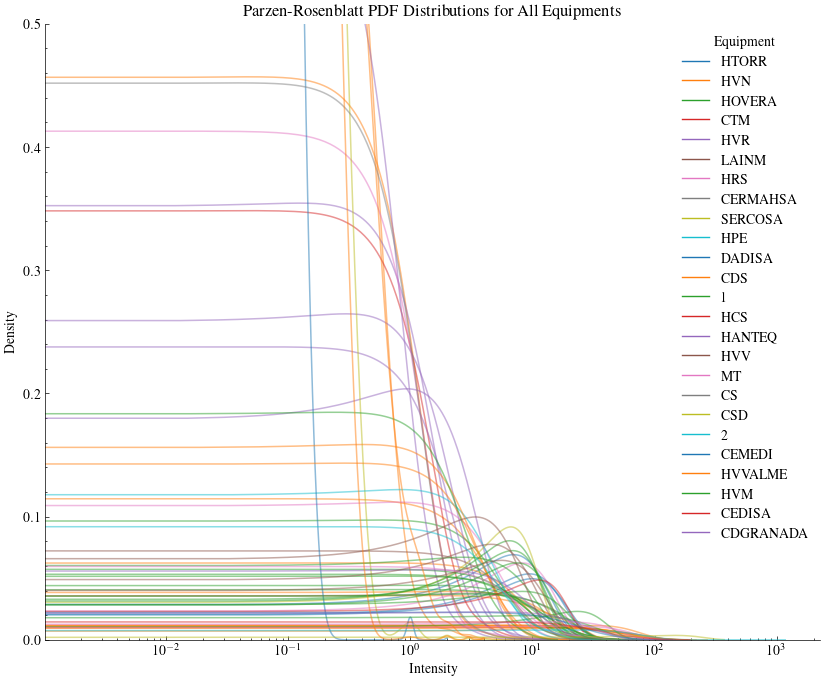

In [7]:
patient_machine = metadata.loc[:, (metadata.columns == "PACIENTE") | (metadata.columns == "EQUIPO")].dropna()

# Parameters
pulse = 'T1'
sigma = 1  # Sigma value for KDE

# Initialize image processing
processing = ImageProcessing()

def plot_kde_all_machines(patient_machine, pulse, sigma):
    """
    Plot the Parzen-Rosenblatt PDF for noise outside the bounding box for each machine.
    All machines are plotted on the same figure with unique colors. 
    The legend only includes machine names, while each patient’s PDF is colored based on their machine.
    """
    # Define color cycle for machines
    color_cycle = cycle(plt.cm.tab10.colors)  # Use matplotlib's tab10 color cycle for distinct colors

    plt.figure(figsize=(10, 8))
    
    # Iterate over each unique equipment
    for equipment in patient_machine['EQUIPO'].unique():
        color = next(color_cycle)
        kde_distributions = []
        
        # Find patients associated with this equipment
        patients = patient_machine[patient_machine['EQUIPO'] == equipment]['PACIENTE']
        
        for patient in patients:
            # Path to the MRI image for this patient and pulse
            rm_nrrd_path = f'/home/mariopasc/Python/Datasets/Meningiomas/Meningioma_Adquisition/RM/{pulse}/P{patient}/{pulse}_P{patient}.nrrd'
            
            # Check if the file exists, if not skip this patient
            if not os.path.exists(rm_nrrd_path):
                print(f"Skipping patient {patient} - file not found for pulse {pulse}.")
                continue
            
            # Process the image
            image = processing.open_nrrd_file(rm_nrrd_path)
            axis = processing.get_transversal_axis(rm_nrrd_path)
            original_im = processing.extract_middle_transversal_slice(image, transversal_axis=axis)
            
            # Segment and find the noise outside bounding box
            mask = segment_mri_image(original_im)
            mask = fill_mask(mask, structure_size=7, iterations=3)
            largest_bbox_margin = find_largest_bbox(mask, extra_margin=(5, 5, 5, 5))
            noise_outside_bbox = extract_noise_outside_bbox(image=original_im, bbox=largest_bbox_margin, mask=mask)
            
            # Calculate KDE PDF for noise values
            kde_pdf = kde(noise_outside_bbox, sigma=sigma)
            kde_distributions.append((kde_pdf, noise_outside_bbox))
        
        ax = plt.subplot(111)
        # Plot KDEs for each patient in this machine with the same color
        for kde_pdf, noise_values in kde_distributions:
            x = np.linspace(np.min(noise_values), np.max(noise_values), 1000)
            plt.plot(x, kde_pdf, color=color, alpha=0.5, linewidth=1.1)  # Lower alpha to overlay multiple KDEs smoothly
        
        # Add legend entry for this equipment
        plt.plot([], [], color=color, label=equipment)  # Dummy plot for legend

    # Final plot adjustments
    plt.title(f'Parzen-Rosenblatt PDF Distributions for All Equipments')
    plt.xlabel('Intensity')
    # Set axis limits
    #plt.xlim(0, 60)
    plt.ylim(0, 0.5)
    ax.spines[['right', 'top']].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    plt.tick_params(top=False, right=False)  
    plt.ylabel('Density')
    ax.set_xscale('log')
    plt.legend(title="Equipment", loc="upper right")
    plt.savefig("../docs/figures/Parzen_Rosenblatt_PDF_for_All_Equipments.png")
    plt.show()

# Run the function
plot_kde_all_machines(patient_machine, pulse, sigma)


### Parzen Rosenblatt per RM Pulse

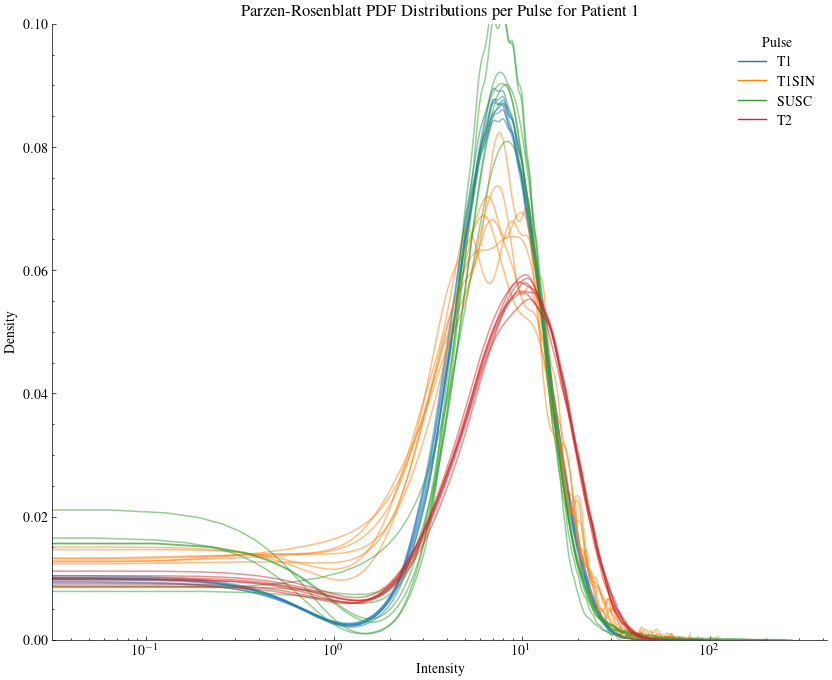

In [4]:

# Load metadata
metadata = pd.read_excel(io=METADATA_PATH, header=1)
patient_machine = metadata.loc[:, (metadata.columns == "PACIENTE") | (metadata.columns == "EQUIPO")].dropna()

# Parameters
sigma = .1  # Sigma value for KDE
NUMBER_SLICES = 3  # Define the number of slices to take around the middle

# Initialize image processing
processing = ImageProcessing()

def find_valid_patient_with_pulses(metadata, pulses):
    """
    Find a patient with valid NRRD files for all required pulses.
    """
    for patient in metadata['PACIENTE'].unique():
        valid = True
        for pulse in pulses:
            rm_nrrd_path = f"{DATASET_FOLDER}/RM/{pulse}/P{patient}/{pulse}_P{patient}.nrrd"
            if not os.path.exists(rm_nrrd_path):
                valid = False
                break
        if valid:
            return patient
    return None

def plot_kde_per_pulse(patient, pulses, num_slices, sigma):
    """
    Plot Parzen-Rosenblatt PDF for a specified patient and given pulses.
    """
    plt.figure(figsize=(10, 8))
    colors = cycle(plt.cm.tab10.colors)  # Color for each pulse
    ax = plt.subplot(111)
    for pulse in pulses:
        color = next(colors)
        
        # Load and process images for each slice around the middle
        rm_nrrd_path = f"{DATASET_FOLDER}/RM/{pulse}/P{patient}/{pulse}_P{patient}.nrrd"
        image = processing.open_nrrd_file(rm_nrrd_path)
        axis = processing.get_transversal_axis(rm_nrrd_path)
        middle_slice_index = image.shape[axis] // 2
        kde_distributions = []
        
        for i in range(-num_slices, num_slices + 1):
            slice_index = middle_slice_index + i
            sliced_image = np.take(image, slice_index, axis=axis)

            # Segment and extract noise from outside the bounding box
            mask = segment_mri_image(sliced_image)
            mask = fill_mask(mask, structure_size=7, iterations=3)
            largest_bbox_margin = find_largest_bbox(mask, extra_margin=(5, 5, 5, 5))
            noise_outside_bbox = extract_noise_outside_bbox(image=sliced_image, bbox=largest_bbox_margin, mask=mask)
            
            # Calculate KDE PDF for noise values
            kde_pdf = kde(noise_outside_bbox, sigma=sigma)
            kde_distributions.append((kde_pdf, noise_outside_bbox))
        
        # Plot KDE distributions for this pulse
        for kde_pdf, noise_values in kde_distributions:
            x = np.linspace(np.min(noise_values), np.max(noise_values), 1000)
            plt.plot(x, kde_pdf, color=color, alpha=0.5, linewidth=1.1)
        
        # Add legend entry for the pulse
        plt.plot([], [], color=color, label=pulse)

    # Final plot adjustments
    plt.title(f'Parzen-Rosenblatt PDF Distributions per Pulse for Patient {patient}')
    plt.xlabel('Intensity')
    plt.ylabel('Density')
    #plt.xlim(0, 60)  # Adjust if necessary
    plt.ylim(0, 0.1)
    ax.spines[['right', 'top']].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.set_xscale('log')
    plt.legend(title="Pulse", loc="upper right")
    plt.show()

# Find a valid patient with all pulses
patient = find_valid_patient_with_pulses(metadata, PULSES)
if patient:
    plot_kde_per_pulse(patient, PULSES, NUMBER_SLICES, sigma)
else:
    print("No patient found with all required pulses.")

### Parzen Rosenblatt PDF per $\sigma$ and pulse

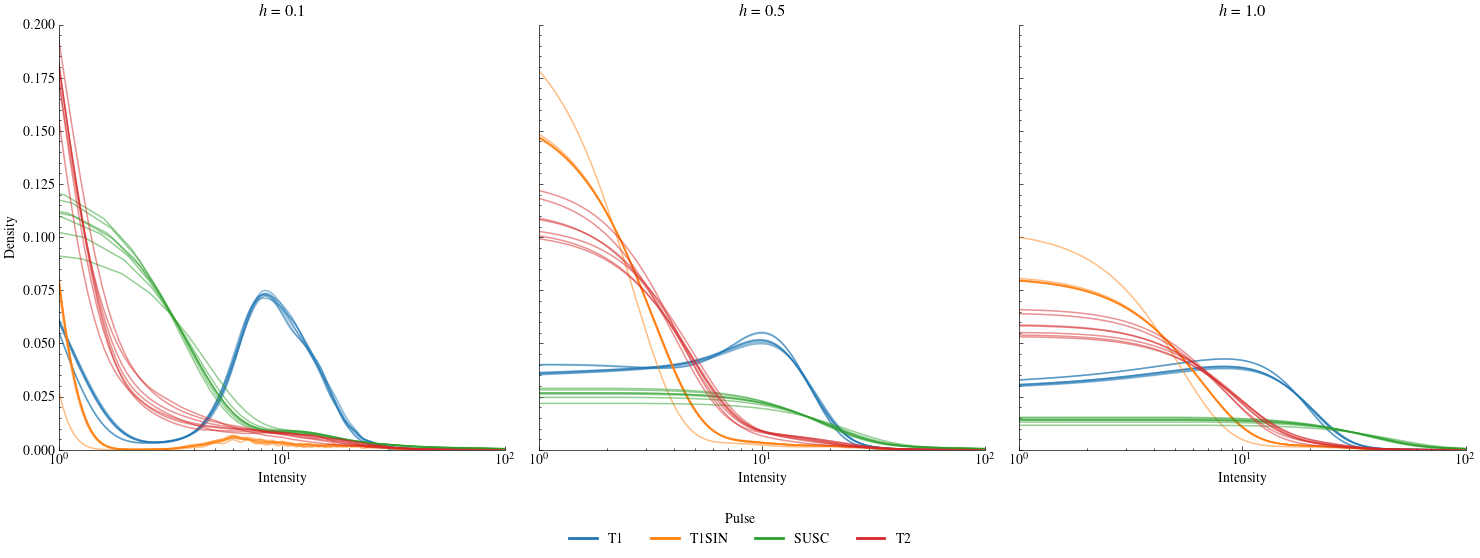

In [11]:
# User-defined parameters
NUMBER_SLICES = 3  # Define the number of slices to take around the middle
H_VALUES = [0.1, 0.5, 1.0]  # List of sigma values for KDE

# Initialize image processing
processing = ImageProcessing()

def find_valid_patient_with_pulses(metadata, pulses):
    """
    Find a patient with valid NRRD files for all required pulses.
    """
    for patient in metadata['PACIENTE'].unique():
        valid = True
        for pulse in pulses:
            rm_nrrd_path = f"{DATASET_FOLDER}/RM/{pulse}/P{patient}/{pulse}_P{patient}.nrrd"
            if not os.path.exists(rm_nrrd_path):
                valid = False
                break
        if valid:
            return patient
    return None

def plot_kde_per_pulse_multiple_sigma(patient, pulses, num_slices, h_values):
    """
    Plot Parzen-Rosenblatt PDF for a specified patient and given pulses
    with multiple sigma values, arranged in a single row of subplots.
    """
    fig, axes = plt.subplots(1, len(h_values), figsize=(15, 6), sharey=True)
    colors = cycle(plt.cm.tab10.colors)  # Color cycle for pulses
    
    for ax, sigma in zip(axes, h_values):
        color_cycle = cycle(plt.cm.tab10.colors)  # Reset color cycle for each sigma value
        
        for pulse in pulses:
            color = next(color_cycle)
            
            # Load and process images for each slice around the middle
            rm_nrrd_path = f"{DATASET_FOLDER}/RM/{pulse}/P{patient}/{pulse}_P{patient}.nrrd"
            image = processing.open_nrrd_file(rm_nrrd_path)
            axis = processing.get_transversal_axis(rm_nrrd_path)
            middle_slice_index = image.shape[axis] // 2
            kde_distributions = []
            
            for i in range(-num_slices, num_slices + 1):
                slice_index = middle_slice_index + i
                sliced_image = np.take(image, slice_index, axis=axis)

                # Segment and extract noise from outside the bounding box
                mask = segment_mri_image(sliced_image)
                mask = fill_mask(mask, structure_size=7, iterations=3)
                largest_bbox_margin = find_largest_bbox(mask, extra_margin=(5, 5, 5, 5))
                noise_outside_bbox = extract_noise_outside_bbox(image=sliced_image, bbox=largest_bbox_margin, mask=mask)
                
                # Calculate KDE PDF for noise values
                kde_pdf = kde(noise_outside_bbox, sigma=sigma)
                kde_distributions.append((kde_pdf, noise_outside_bbox))
            
            # Plot KDE distributions for this pulse
            for kde_pdf, noise_values in kde_distributions:
                x = np.linspace(np.min(noise_values), np.max(noise_values), 1000)
                ax.plot(x, kde_pdf, color=color, alpha=0.5, linewidth=1.1)
        
        # Title and axis settings for each subplot
        ax.set_title(f'$h$ = {sigma}')
        ax.set_xlabel('Intensity')
        ax.set_xlim(1, 100)  # Adjust if necessary
        ax.set_ylim(0, .2)  # Adjust if necessary
        ax.set_xscale('log')  # Optional, depending on data distribution
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        
    # Y-axis label only on the leftmost plot
    axes[0].set_ylabel('Density')

    # Add a single legend below all plots
    handles = [plt.Line2D([0], [0], color=next(colors), lw=2) for _ in pulses]
    labels = pulses
    fig.legend(handles, labels, title="Pulse", loc="lower center", ncol=len(pulses))
    
    # Adjust layout and show plot
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Leave space at the bottom for the legend
    plt.savefig(f"../docs/figures/PR_PDF_per_sigma_pulse_same_patient_P{patient}.png")
    plt.savefig(f"../docs/figures/PR_PDF_per_sigma_pulse_same_patient_P{patient}.pdf")
    plt.show()

# Find a valid patient with all pulses
patient = find_valid_patient_with_pulses(metadata, PULSES)
if patient:
    plot_kde_per_pulse_multiple_sigma(72, PULSES, NUMBER_SLICES, h_values=H_VALUES)
else:
    print("No patient found with all required pulses.")

We should check if the discrepancies between the estimated PDF's among the studied slices are related to our segmentation algorithm performing poorly. For this end, let's plot the bbox of the studied slices.

Valid patients: [1, 5, 6, 7, 12, 14, 15, 16, 19, 21, 22, 24, 26, 29, 35, 36, 40, 42, 45, 50, 52, 57, 68, 72, 73]


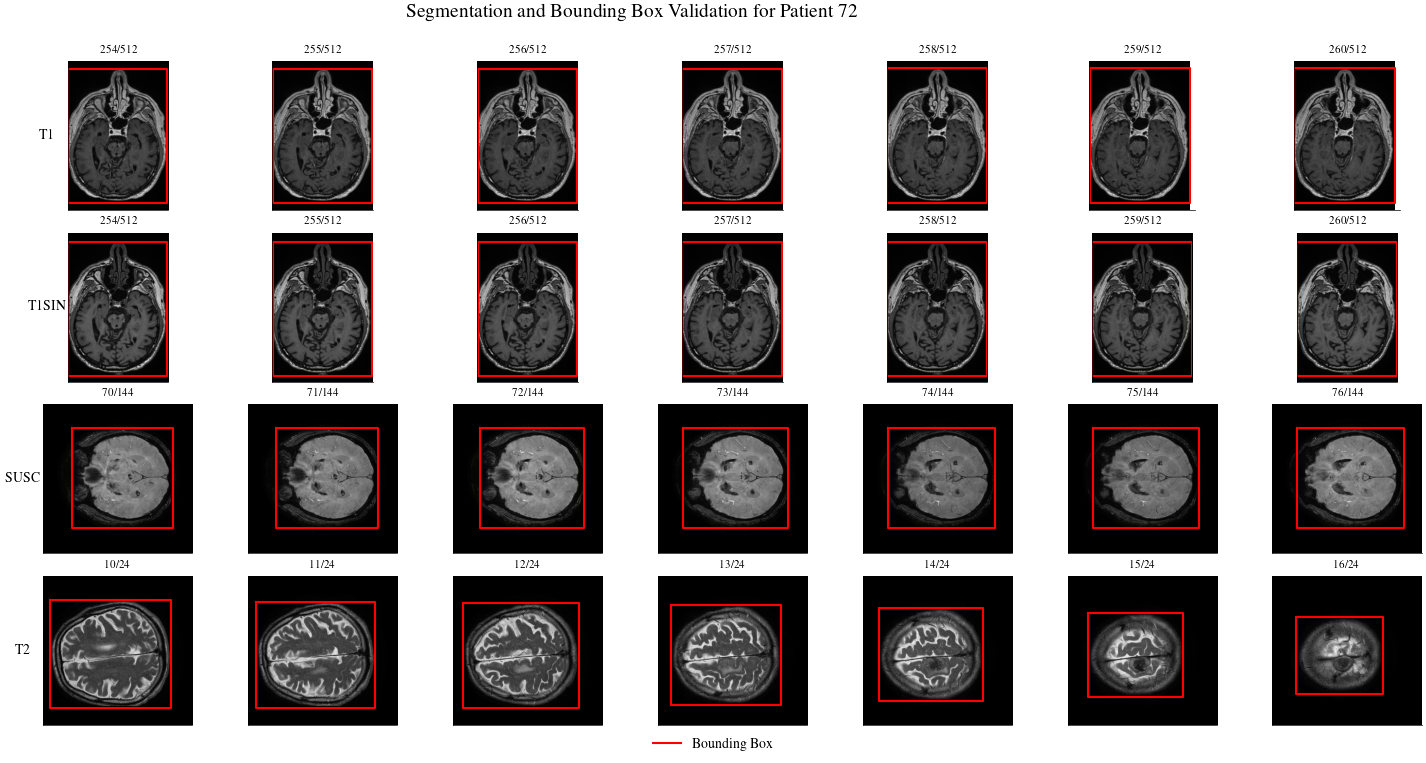

In [15]:

# Set up paths and parameters
DATASET_FOLDER = "/home/mariopasc/Python/Datasets/Meningiomas/Meningioma_Adquisition"
METADATA_PATH = os.path.join(DATASET_FOLDER, "metadata.xlsx")
PULSES = ['T1', 'T1SIN', 'SUSC', 'T2']
NUMBER_SLICES = 3  # Number of slices around the middle to include

# Load metadata
metadata = pd.read_excel(io=METADATA_PATH, header=1)
patient_machine = metadata.loc[:, (metadata.columns == "PACIENTE") | (metadata.columns == "EQUIPO")].dropna()

# Initialize image processing
processing = ImageProcessing()

def find_valid_patient_with_pulses(metadata, pulses):
    """
    Find a patient with valid NRRD files for all required pulses.
    """
    valid_patients = []
    for patient in metadata['PACIENTE'].unique():
        valid = True
        for pulse in pulses:
            rm_nrrd_path = f"{DATASET_FOLDER}/RM/{pulse}/P{patient}/{pulse}_P{patient}.nrrd"
            if not os.path.exists(rm_nrrd_path):
                valid = False
                break
        if valid:
            valid_patients.append(patient)
    return valid_patients

def plot_segmentation_validation(patient, pulses, num_slices):
    """
    Plot validation of brain segmentation with bounding boxes for each pulse and slice.
    """
    fig, axes = plt.subplots(len(pulses), 2 * num_slices + 1, figsize=(20, 8))
    fig.suptitle(f'Segmentation and Bounding Box Validation for Patient {patient}', y=0.95, fontsize=14)
    
    for row, pulse in enumerate(pulses):
        # Load MRI data for the pulse
        rm_nrrd_path = f"{DATASET_FOLDER}/RM/{pulse}/P{patient}/{pulse}_P{patient}.nrrd"
        image = processing.open_nrrd_file(rm_nrrd_path)
        axis = processing.get_transversal_axis(rm_nrrd_path)
        total_slices = image.shape[axis]  # Get total number of slices for the study
        middle_slice_index = total_slices // 2

        for col, offset in enumerate(range(-num_slices, num_slices + 1)):
            slice_index = middle_slice_index + offset
            sliced_image = np.take(image, slice_index, axis=axis)

            # Segment and find the largest bounding box
            mask = segment_mri_image(sliced_image)
            mask = fill_mask(mask, structure_size=7, iterations=3)
            largest_bbox_margin = find_largest_bbox(mask, extra_margin=(5, 5, 5, 5))
            
            # Plot the image with bounding box
            ax = axes[row, col]
            ax.imshow(sliced_image, cmap='gray')
            min_row, min_col, max_row, max_col = largest_bbox_margin
            ax.plot([min_col, max_col, max_col, min_col, min_col],
                    [min_row, min_row, max_row, max_row, min_row], 'r-', lw=1.5)
            # Title format with the slice number out of the total slices
            ax.set_title(f"{slice_index + 1}/{total_slices}", fontsize=8)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.tick_params(left=False, bottom=False)  # Disables tick marks
            
            # Set the y-label for the first column
            if col == 0:
                ax.set_ylabel(pulse, rotation=0, labelpad=15, fontsize=10, ha='center', va='center')

    # Add legend for bounding box
    fig.legend([plt.Line2D([0], [0], color="red", lw=1.5)], 
               ["Bounding Box"], loc="lower center", fontsize=10, ncol=1, frameon=False)
    
    # Adjust layout and spacing
    plt.subplots_adjust(hspace=0.15, wspace=0.2, left=0.2, bottom=0.05)  # Reduced hspace for closer rows
    plt.savefig(f"../docs/figures/segmentation_per_pulse_P{patient}.png")
    plt.savefig(f"../docs/figures/segmentation_per_pulse_P{patient}.pdf")
    plt.show()

# Find a valid patient with all pulses
patients = find_valid_patient_with_pulses(metadata, PULSES)

print(f"Valid patients: {patients}")

if len(patients) != 0:
    plot_segmentation_validation(72, PULSES, NUMBER_SLICES)
else:
    print("No patient found with all required pulses.")

Calculating pixel counts for patient 5:  90%|█████████ | 9/10 [00:26<00:03,  3.93s/it]

Calculating pixel counts for patient 5: 100%|██████████| 10/10 [00:31<00:00,  3.17s/it]


Calculating pixel counts for patient 6: 100%|██████████| 10/10 [02:18<00:00, 13.88s/it]


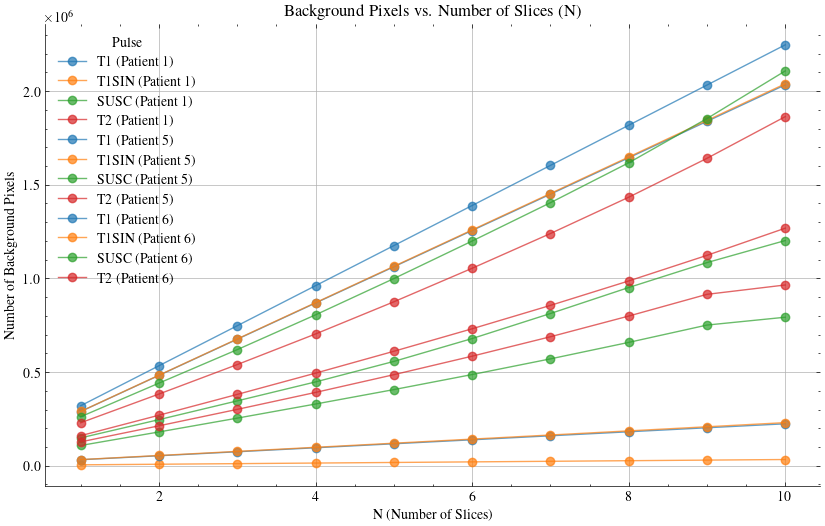

In [36]:
# Set up paths and parameters
DATASET_FOLDER = "/home/mariopasc/Python/Datasets/Meningiomas/Meningioma_Adquisition"
METADATA_PATH = os.path.join(DATASET_FOLDER, "metadata.xlsx")
PULSES = ['T1', 'T1SIN', 'SUSC', 'T2']
N_VALUES = range(1, 11)  # Define a range of N values to test (e.g., 1 to 10)
NUM_PATIENTS = 3  # Define the number of patients to include in the study

# Load metadata
metadata = pd.read_excel(io=METADATA_PATH, header=1)
patient_machine = metadata.loc[:, (metadata.columns == "PACIENTE") | (metadata.columns == "EQUIPO")].dropna()

# Initialize image processing
processing = ImageProcessing()

def find_valid_patients_with_pulses(metadata, pulses, num_patients):
    """
    Find multiple patients with valid NRRD files for all required pulses.
    """
    valid_patients = []
    for patient in metadata['PACIENTE'].unique():
        if len(valid_patients) >= num_patients:
            break
        valid = True
        for pulse in pulses:
            rm_nrrd_path = f"{DATASET_FOLDER}/RM/{pulse}/P{patient}/{pulse}_P{patient}.nrrd"
            if not os.path.exists(rm_nrrd_path):
                valid = False
                break
        if valid:
            valid_patients.append(patient)
    return valid_patients

def count_background_pixels(patient, pulse, num_slices):
    """
    Count the number of background pixels for a given patient, pulse, and number of slices.
    If the slice index is out of bounds, stop and return the count so far.
    """
    rm_nrrd_path = f"{DATASET_FOLDER}/RM/{pulse}/P{patient}/{pulse}_P{patient}.nrrd"
    image = processing.open_nrrd_file(rm_nrrd_path)
    axis = processing.get_transversal_axis(rm_nrrd_path)
    middle_slice_index = image.shape[axis] // 2
    total_pixels = 0

    for offset in range(-num_slices, num_slices + 1):
        slice_index = middle_slice_index + offset
        
        # Check if slice_index is within the bounds of available slices
        if slice_index < 0 or slice_index >= image.shape[axis]:
            print(f"Warning: Slice index {slice_index} out of bounds for pulse {pulse} (Patient {patient}). Returning pixel count so far.")
            return total_pixels  # Return accumulated pixels up to this point
        
        sliced_image = np.take(image, slice_index, axis=axis)

        # Segment the image to isolate background pixels
        mask = segment_mri_image(sliced_image)
        mask = fill_mask(mask, structure_size=7, iterations=3)

        # Count background pixels (where mask == 0)
        total_pixels += np.sum(mask == 0)
    
    return total_pixels

def estimate_pixel_counts(patients, n_values, pulses):
    """
    Estimate pixel counts for different N values and each pulse for multiple patients.
    """
    patient_pixel_counts = {patient: {pulse: [] for pulse in pulses} for patient in patients}
    
    for patient in patients:
        for n in tqdm(n_values, desc=f"Calculating pixel counts for patient {patient}"):
            for pulse in pulses:
                pixel_count = count_background_pixels(patient, pulse, n)
                patient_pixel_counts[patient][pulse].append(pixel_count)
    
    return patient_pixel_counts

def plot_pixel_counts(n_values, patient_pixel_counts):
    """
    Plot the pixel counts as a function of N values for each pulse across multiple patients.
    """
    plt.figure(figsize=(10, 6))
    colors = cycle(plt.cm.tab10.colors)  # Define a color cycle for pulses
    pulse_colors = {pulse: next(colors) for pulse in PULSES}  # Assign a consistent color to each pulse

    for patient, pixel_counts in patient_pixel_counts.items():
        for pulse, counts in pixel_counts.items():
            plt.plot(n_values, counts, marker='o', color=pulse_colors[pulse], alpha=0.7, label=f"{pulse} (Patient {patient})")
    
    # Add legend only once per pulse (avoiding multiple entries for each patient-pulse combination)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicates by using a dictionary
    plt.legend(by_label.values(), by_label.keys(), title="Pulse", loc="upper left")

    plt.title("Background Pixels vs. Number of Slices (N)")
    plt.xlabel("N (Number of Slices)")
    plt.ylabel("Number of Background Pixels")
    plt.grid(True)
    plt.show()

# Find valid patients with all pulses
patients = find_valid_patients_with_pulses(metadata, PULSES, NUM_PATIENTS)
if patients:
    patient_pixel_counts = estimate_pixel_counts(patients, N_VALUES, PULSES)
    plot_pixel_counts(N_VALUES, patient_pixel_counts)
else:
    print("No patients found with all required pulses.")

### Pareto Front

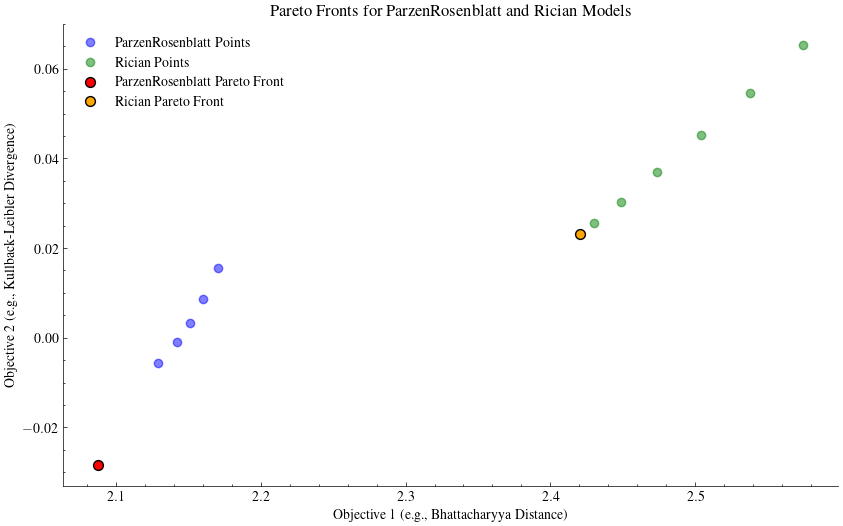

[[2.4204866  0.02321731]]


,Pulse,Patient,Model,Hyperparameter,Bhattacharyya,Kullback-Leibler
0,T1,1,ParzenRosenblatt,0.05,-0.028370,2.088013
1,T1,1,ParzenRosenblatt,0.10,-0.005564,2.129061
2,T1,1,ParzenRosenblatt,0.20,-0.000970,2.142030
3,T1,1,ParzenRosenblatt,0.30,0.003174,2.151108
4,T1,1,ParzenRosenblatt,0.40,0.008535,2.160074
5,T1,1,ParzenRosenblatt,0.50,0.015612,2.170918
6,T1,1,Rician,9.00,0.023217,2.420487
7,T1,1,Rician,9.50,0.025628,2.430239
8,T1,1,Rician,10.00,0.030333,2.448668
9,T1,1,Rician,10.50,0.036949,2.473691


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
plt.style.use(['science', 'ieee', 'std-colors'])
plt.rcParams['font.size'] = 10
plt.rcParams.update({'figure.dpi': '100'})
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
# Sample Data (using the data you provided in CSV format for clarity)
path = "/home/mariopasc/Python/Results/Meningioma/dataset_crafting/results.csv"

df = pd.read_csv(path)
df = df[df["Hyperparameter"] != 0.01]

def keep_efficient(pts):
    'returns Pareto efficient row subset of pts'
    # sort points by decreasing sum of coordinates
    pts = pts[pts.sum(1).argsort()[::-1]]
    # initialize a boolean mask for undominated points
    # to avoid creating copies each iteration
    undominated = np.ones(pts.shape[0], dtype=bool)
    for i in range(pts.shape[0]):
        # process each point in turn
        n = pts.shape[0]
        if i >= n:
            break
        # find all points not dominated by i
        # since points are sorted by coordinate sum
        # i cannot dominate any points in 1,...,i-1
        undominated[i+1:n] = (pts[i+1:] >= pts[i]).any(1) 
        # keep points undominated so far
        pts = pts[undominated[:n]]
    return pts

T1 = df[df["Pulse"] == "T1"]

points_rician = T1[T1["Model"] == "Rician"].iloc[:, [-1, -2]].values
points_pr = T1[T1["Model"] == "ParzenRosenblatt"].iloc[:, [-1, -2]].values

# Define the function to calculate the Pareto front, reused from previous example
def pareto_front(data: np.ndarray) -> np.ndarray:
    """
    Identifies the Pareto front from a set of data points.

    Parameters:
    - data (np.ndarray): A 2D array where each row is a point with two objective values.

    Returns:
    - np.ndarray: A subset of `data` representing the Pareto front.
    """
    num_points = data.shape[0]
    is_pareto = np.ones(num_points, dtype=bool)
    
    for i in range(num_points):
        for j in range(num_points):
            if all(data[j] <= data[i]) and any(data[j] < data[i]):
                is_pareto[i] = False
                break

    return data[is_pareto]

# Calculate the Pareto fronts for both series
pareto_points_pr = pareto_front(points_pr)
pareto_points_rician = pareto_front(points_rician)

# Plotting the points and their respective Pareto fronts
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

# Plot all points for each series
plt.scatter(points_pr[:, 0], points_pr[:, 1], label="ParzenRosenblatt Points", color="blue", alpha=0.5)
plt.scatter(points_rician[:, 0], points_rician[:, 1], label="Rician Points", color="green", alpha=0.5)

# Plot the Pareto fronts
plt.scatter(pareto_points_pr[:, 0], pareto_points_pr[:, 1], label="ParzenRosenblatt Pareto Front", color="red", edgecolor="black", s=50)
plt.scatter(pareto_points_rician[:, 0], pareto_points_rician[:, 1], label="Rician Pareto Front", color="orange", edgecolor="black", s=50)

# Labeling and styling
plt.xlabel("Objective 1 (e.g., Bhattacharyya Distance)")
plt.ylabel("Objective 2 (e.g., Kullback-Leibler Divergence)")
plt.title("Pareto Fronts for ParzenRosenblatt and Rician Models")
plt.legend()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.savefig("./pareto_front.png")
plt.show()

print(pareto_points_rician)
df

In [2]:
from sklearn.model_selection import train_test_split
from metrics import Metrics
from image_processing import ImageProcessing
import pandas as pd
import numpy as np

results_df = pd.DataFrame(columns=['Pulse', 'Patient', 'Model', 'Hyperparameter', 'Bhattacharyya', 'Kullback-Leibler'])
H_VALUES = [0.05]        # Bandwidths for KDE models
SIGMA_VALUES = [1]    # Sigma values for Rician distribution
N_SLICES = 5                       # Number of slices around the middle slice
PULSE_TYPES = ['T1']
TRAIN_TEST_SPLIT = 0.67            # Percentage for train set
RANDOM_SEED = 42                   # Seed for reproducibility
DATASET_FOLDER = "/home/mariopasc/Python/Datasets/Meningiomas/Meningioma_Adquisition"

patient_ids = [1]

for pulse in PULSE_TYPES:
    for patient_id in patient_ids:
        nrrd_path = f"{DATASET_FOLDER}/RM/{pulse}/P{patient_id}/{pulse}_P{patient_id}.nrrd"
        
        # 1. Load MRI Image
        image_data = ImageProcessing.open_nrrd_file(nrrd_path)
        transversal_axis = ImageProcessing.get_transversal_axis(nrrd_path)
        mid_slice_idx = image_data.shape[transversal_axis] // 2
        
        # 2. Extract 2N+1 slices around the middle slice
        slices = [ImageProcessing.extract_transversal_slice(image_data, transversal_axis, slice_index=mid_slice_idx + offset)
                    for offset in range(-N_SLICES, N_SLICES + 1)]

        # Split slices into train and test sets at the image level
        train_slices, test_slices = train_test_split(
            slices, train_size=TRAIN_TEST_SPLIT, random_state=RANDOM_SEED
        )

        # Training Phase: Collect noise data from all training slices
        train_noise_data = []
        for img in train_slices:
            mask = ImageProcessing.segment_intracraneal_region(img)
            filled_mask = ImageProcessing.fill_mask(mask)
            bbox = ImageProcessing.find_largest_bbox(filled_mask)
            noise_values = ImageProcessing.extract_noise_outside_bbox(img, bbox, filled_mask)
            train_noise_data.extend(noise_values)
        train_noise_data = np.array(train_noise_data)

        # Train Parzen-Rosenblatt KDE models with different h values
        kde_models = {h: ImageProcessing.kde(train_noise_data, h=h, return_x_values=False) for h in H_VALUES}

        # Testing Phase: Collect noise data from all test slices
        test_noise_data = []
        for img in test_slices:
            mask = ImageProcessing.segment_intracraneal_region(img)
            filled_mask = ImageProcessing.fill_mask(mask)
            bbox = ImageProcessing.find_largest_bbox(filled_mask)
            noise_values = ImageProcessing.extract_noise_outside_bbox(img, bbox, filled_mask)
            test_noise_data.extend(noise_values)
        test_noise_data = np.array(test_noise_data)

        # Generate x_values for model evaluations
        x_values = np.linspace(np.min(test_noise_data), np.max(test_noise_data), 1000)

        # Create Rician models with different sigma values
        rician_models = {sigma: ImageProcessing.rician(x_values, sigma) for sigma in SIGMA_VALUES}

        # Evaluate Parzen-Rosenblatt models with test data
        for h, kde_pdf in kde_models.items():
            # Compute Bhattacharyya's and KL Divergences
            bhattacharyya_distance = Metrics.compute_bhattacharyya_distance(test_noise_data, kde_pdf)
            kl_divergence = Metrics.compute_kl_divergence(test_noise_data, kde_pdf)

            # Record results for Parzen-Rosenblatt model
            results_df.loc[len(results_df)] = [pulse, patient_id, 'ParzenRosenblatt', h, bhattacharyya_distance, kl_divergence]

        # Evaluate Rician models with test data
        for sigma, rician_pdf in rician_models.items():
            # Compute Bhattacharyya's and KL Divergences
            bhattacharyya_distance = Metrics.compute_bhattacharyya_distance(test_noise_data, rician_pdf)
            kl_divergence = Metrics.compute_kl_divergence(test_noise_data, rician_pdf)

            # Record results for Rician model
            results_df.loc[len(results_df)] = [pulse, patient_id, 'Rician', sigma, bhattacharyya_distance, kl_divergence]

results_df

,Pulse,Patient,Model,Hyperparameter,Bhattacharyya,Kullback-Leibler
0,T1,1,ParzenRosenblatt,0.05,-0.028370,2.088013
1,T1,1,Rician,1.00,2.508092,19.425033


In [21]:
def compute_bhattacharyya_distance(noise_values: np.ndarray, reference_pdf: np.ndarray, x_values:np.ndarray, epsilon: float = 1e-10) -> float:
    """
    Compute the Bhattacharyya distance between an empirical noise distribution
    and a KDE-estimated distribution.

    Parameters:
    - noise_values (np.ndarray): Original noise values outside the bounding box.
    - reference_pdf (np.ndarray): Discrete KDE-estimated PDF values.
    - epsilon (float): Small value to prevent log(0) issues.

    Returns:
    - float: Bhattacharyya distance between the empirical and KDE distributions.
    """
    # Step 1: Discretize the reference PDF into probability masses
    dx = x_values[1] - x_values[0]  # Width of each small interval
    prob_masses = reference_pdf * dx  # Approximate probability masses
    prob_masses /= np.sum(prob_masses)  # Normalize to sum to 1

    # Step 2: Create empirical probability distribution from noise_values
    # Use the same bins as x_values for histogram
    hist_counts, _ = np.histogram(noise_values, bins=np.append(x_values, x_values[-1] + dx), density=False)
    noise_prob_masses = hist_counts.astype(float) / np.sum(hist_counts)  # Normalize to sum to 1

    # Step 3: Compute the Bhattacharyya coefficient
    bc_coefficient = np.sum(np.sqrt(noise_prob_masses * prob_masses)) + epsilon  # Add epsilon for numerical stability
    bhattacharyya_distance = -np.log(bc_coefficient)
    
    return bhattacharyya_distance

def compute_kl_divergence(noise_values: np.ndarray, reference_pdf: np.ndarray, x_values: np.ndarray, epsilon: float = 1e-10) -> float:
    """
    Compute the Kullback-Leibler divergence between an empirical noise distribution
    and a KDE-estimated distribution, adding epsilon to avoid division by zero.

    Parameters:
    - noise_values (np.ndarray): Original noise values outside the bounding box.
    - reference_pdf (np.ndarray): Discrete KDE-estimated PDF values evaluated at x_values.
    - x_values (np.ndarray): The x-values over which the PDFs are evaluated.
    - epsilon (float): Small value to prevent division by zero.

    Returns:
    - float: KL divergence between the empirical and KDE distributions.
    """
    # Step 1: Discretize the reference PDF into probability masses
    dx = x_values[1] - x_values[0]  # Width of each small interval
    prob_masses = reference_pdf * dx  # Approximate probability masses
    prob_masses += epsilon  # Add epsilon to avoid zeros
    prob_masses /= np.sum(prob_masses)  # Normalize to sum to 1

    # Step 2: Create empirical probability distribution from noise_values
    # Use the same bins as x_values for histogram
    bins = np.append(x_values, x_values[-1] + dx)  # Ensure the last bin captures the max value
    hist_counts, _ = np.histogram(noise_values, bins=bins, density=False)
    noise_prob_masses = hist_counts.astype(float) + epsilon  # Add epsilon to avoid zeros
    noise_prob_masses /= np.sum(noise_prob_masses)  # Normalize to sum to 1

    # Step 3: Compute KL divergence
    kl_divergence = np.sum(noise_prob_masses * np.log(noise_prob_masses / prob_masses))
    
    return kl_divergence

pdf_values, x_values = ImageProcessing.kde(noise_values=train_noise_data, h = 0.001, return_x_values=True)

compute_bhattacharyya_distance(noise_values=test_noise_data,
                               reference_pdf=pdf_values,
                               x_values=x_values)
compute_kl_divergence(noise_values=test_noise_data,
                               reference_pdf=pdf_values,
                               x_values=x_values)

14.541972531445337

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose we have the following
noise_values = np.random.normal(0, 1, size=500)  # 500 data points
x_values = np.linspace(-5, 5, 1000)  # 1000 points for KDE
reference_pdf = kde(x_values)  # KDE evaluated at x_values

# Compute histograms and probability masses
dx = x_values[1] - x_values[0]
prob_masses = reference_pdf * dx
prob_masses /= np.sum(prob_masses)

hist_counts, _ = np.histogram(noise_values, bins=np.append(x_values, x_values[-1] + dx), density=False)
noise_prob_masses = hist_counts.astype(float)
noise_prob_masses /= np.sum(noise_prob_masses)

# Now prob_masses and noise_prob_masses both have length 1000
print(len(prob_masses))         # Output: 1000
print(len(noise_prob_masses))   # Output: 1000

# Compute the Bhattacharyya distance or KL divergence using these arrays


1000
1000
